# Scenario
Create a model that will predict whether a airbnb will get a perfect 5.0 rating in San Diego California. The purpose of this model is for airbnb hosts to have a way to evaluate their rentals and make sure that they are meeting all of the criteria to get that perfect review.

## Questions to Answer

1. How many units have a perfect rating?
2. How long have they had perfect rating?
3. How many reviews should the unit have to be considered? (ie, one 5.0 isn't enough)
4. What review metrics have the most impact?
5. What house factors have the most impact?
6. Relationship between price and rating?

## Loading Data

In [1]:
import warnings
warnings.filterwarnings('ignore')
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
%matplotlib inline
import matplotlib.ticker as mtick
from matplotlib.pylab import rcParams
import matplotlib.ticker as mtick
from sklearn.model_selection import train_test_split, cross_val_score, GridSearchCV
from sklearn.tree import DecisionTreeClassifier
from sklearn.metrics import accuracy_score, mean_squared_error, mean_squared_log_error, roc_curve, auc
from sklearn.metrics import precision_score, recall_score, accuracy_score, f1_score, classification_report
from sklearn.metrics import confusion_matrix
from sklearn.preprocessing import OneHotEncoder, StandardScaler
from sklearn.linear_model import LinearRegression
from sklearn.impute import SimpleImputer
from sklearn import tree
from sklearn.ensemble import RandomForestClassifier
from imblearn.over_sampling import SMOTE
from sklearn.metrics import plot_confusion_matrix
from xgboost import XGBClassifier


In [2]:
pd.set_option('display.max_rows', 1000)
plt.style.use('fivethirtyeight')

## Reviews_df: Details on each review post

In [3]:
reviews_df = pd.read_csv('reviews.csv.gz')

In [4]:
reviews_df.head()

,listing_id,id,date,reviewer_id,reviewer_name,comments
0,29967,62788,2010-07-09,151260,Debbie,When I booked our stay in San Diego at Dennis ...
1,29967,64568,2010-07-14,141552,Eric,This was my first experience with using airbnb...
2,29967,67502,2010-07-22,141591,David,We found the house to be very accommodating--e...
3,29967,70466,2010-07-29,125982,Anders,As advertised and more. Dennis was very helpfu...
4,29967,74876,2010-08-07,29835,Miyoko,We had a great time in San Diego. Denis' house...


## Listing_DF: Baseline DF with many columns

In [5]:
listing_df = pd.read_csv('listings.csv.gz')

In [6]:
listing_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 10935 entries, 0 to 10934
Data columns (total 74 columns):
 #   Column                                        Non-Null Count  Dtype  
---  ------                                        --------------  -----  
 0   id                                            10935 non-null  int64  
 1   listing_url                                   10935 non-null  object 
 2   scrape_id                                     10935 non-null  int64  
 3   last_scraped                                  10935 non-null  object 
 4   name                                          10935 non-null  object 
 5   description                                   10809 non-null  object 
 6   neighborhood_overview                         7440 non-null   object 
 7   picture_url                                   10935 non-null  object 
 8   host_id                                       10935 non-null  int64  
 9   host_url                                      10935 non-null 

In [7]:
listing_df['price']

0         $60.00
1        $282.00
2        $348.00
3        $368.00
4        $264.00
          ...   
10930    $228.00
10931    $168.00
10932    $500.00
10933     $67.00
10934     $88.00
Name: price, Length: 10935, dtype: object

### Fixing Price

In [8]:
listing_df['price'] = listing_df['price'].map(lambda x: x.replace('$',' '))
listing_df['price'] = listing_df['price'].map(lambda x: x.replace(',',''))
listing_df['price'] = listing_df['price'].astype(float)

In [9]:
listing_df['price']

0         60.0
1        282.0
2        348.0
3        368.0
4        264.0
         ...  
10930    228.0
10931    168.0
10932    500.0
10933     67.0
10934     88.0
Name: price, Length: 10935, dtype: float64

## Review Score DF

In [10]:
#review_score_df = listing_df[['id', 'price', 'review_scores_rating', 'review_scores_accuracy',
#                             'review_scores_cleanliness', 'review_scores_checkin', 'review_scores_communication',
#                             'review_scores_location', 'review_scores_value', 'number_of_reviews',
#                             'number_of_reviews_ltm', 'number_of_reviews_l30d']]

In [11]:
listing_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 10935 entries, 0 to 10934
Data columns (total 74 columns):
 #   Column                                        Non-Null Count  Dtype  
---  ------                                        --------------  -----  
 0   id                                            10935 non-null  int64  
 1   listing_url                                   10935 non-null  object 
 2   scrape_id                                     10935 non-null  int64  
 3   last_scraped                                  10935 non-null  object 
 4   name                                          10935 non-null  object 
 5   description                                   10809 non-null  object 
 6   neighborhood_overview                         7440 non-null   object 
 7   picture_url                                   10935 non-null  object 
 8   host_id                                       10935 non-null  int64  
 9   host_url                                      10935 non-null 

In [12]:
review_score_df = listing_df[['price', 'review_scores_rating', 'review_scores_accuracy',
                             'review_scores_cleanliness', 'review_scores_checkin', 'review_scores_communication',
                             'review_scores_location', 'review_scores_value','accommodates',
                              'bedrooms', 'beds', 'instant_bookable',
                             'property_type', 'room_type', 'amenities']]

In [13]:
df = review_score_df

In [14]:
df.head()

,price,review_scores_rating,review_scores_accuracy,review_scores_cleanliness,review_scores_checkin,review_scores_communication,review_scores_location,review_scores_value,accommodates,bedrooms,beds,instant_bookable,property_type,room_type,amenities
0,60.0,5.00,5.00,5.00,5.00,5.00,4.00,5.00,2,1.0,1.0,t,Private room in rental unit,Private room,"[""First aid kit"", ""Private patio or balcony"", ..."
1,282.0,4.87,4.91,4.64,4.99,4.98,4.87,4.86,6,3.0,3.0,f,Entire residential home,Entire home/apt,"[""First aid kit"", ""Ethernet connection"", ""Bike..."
2,348.0,4.92,5.00,4.92,5.00,5.00,4.92,4.92,2,1.0,1.0,t,Entire residential home,Entire home/apt,"[""Shower gel"", ""Private patio or balcony"", ""TV..."
3,368.0,4.88,4.96,4.96,5.00,5.00,4.75,4.71,6,3.0,4.0,t,Entire townhouse,Entire home/apt,"[""First aid kit"", ""Private patio or balcony"", ..."
4,264.0,5.00,5.00,4.75,4.75,4.75,5.00,4.75,4,1.0,1.0,f,Entire serviced apartment,Entire home/apt,"[""First aid kit"", ""Shower gel"", ""Outdoor showe..."


In [15]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 10935 entries, 0 to 10934
Data columns (total 15 columns):
 #   Column                       Non-Null Count  Dtype  
---  ------                       --------------  -----  
 0   price                        10935 non-null  float64
 1   review_scores_rating         9408 non-null   float64
 2   review_scores_accuracy       9385 non-null   float64
 3   review_scores_cleanliness    9385 non-null   float64
 4   review_scores_checkin        9383 non-null   float64
 5   review_scores_communication  9385 non-null   float64
 6   review_scores_location       9383 non-null   float64
 7   review_scores_value          9383 non-null   float64
 8   accommodates                 10935 non-null  int64  
 9   bedrooms                     9905 non-null   float64
 10  beds                         10813 non-null  float64
 11  instant_bookable             10935 non-null  object 
 12  property_type                10935 non-null  object 
 13  room_type       

### New Feature: Capacity Ranges

In [16]:
df['accommodates'].value_counts()

2     2716
4     2306
6     1638
8      841
3      757
5      647
1      604
10     411
7      291
12     224
16     172
9      123
14      99
11      53
15      30
13      20
0        3
Name: accommodates, dtype: int64

In [17]:
df['capacity_0-2'] = df['accommodates'] <= 2

In [18]:
df['capacity_3-4'] = df['accommodates'] == range(3-4)

In [19]:
df['capacity_5-9'] = df['accommodates'] == range(5-9)
df['capacity_10+'] = df['accommodates'] >= 10

### New Feature: Bedroom Ranges

In [20]:
df['bedrooms'].value_counts()

1.0     4621
2.0     2684
3.0     1538
4.0      665
5.0      254
6.0       87
7.0       25
8.0       16
10.0       6
9.0        5
11.0       2
12.0       2
Name: bedrooms, dtype: int64

In [21]:
df['bedrooms_1'] = df['bedrooms'] == 1
df['bedrooms_2'] = df['bedrooms'] == 2
df['bedrooms_3'] = df['bedrooms'] == 3
df['bedrooms_4+'] = df['bedrooms'] >= 4

### Number of Units with a 5.0 Avg Rating

In [22]:
df['review_scores_rating'].value_counts()

5.00    2054
4.80     248
4.91     238
4.86     237
4.88     233
4.89     226
4.83     220
4.92     216
4.67     209
4.96     207
4.94     207
4.90     206
4.50     202
4.93     200
4.75     196
4.95     184
4.85     179
4.97     172
4.87     165
4.00     164
4.82     161
4.84     154
4.98     138
4.81     138
4.79     137
4.78     135
4.76     108
4.73     107
4.71     107
4.70     100
4.74      99
4.77      97
4.60      93
4.72      89
4.69      81
4.63      78
4.68      71
4.65      70
4.64      67
4.99      59
4.33      59
4.57      51
4.58      51
4.62      49
3.00      49
4.59      47
4.66      47
4.56      47
4.61      45
4.40      43
4.53      41
4.44      36
4.52      35
4.54      34
4.55      33
4.43      32
1.00      32
4.25      32
4.38      29
4.47      29
4.46      23
3.67      23
4.51      22
4.42      22
4.48      22
4.45      20
0.00      19
4.20      19
4.32      18
3.50      18
4.39      17
4.29      17
4.41      14
4.35      12
4.17      12
2.00      12
4.14      11

In [23]:
df['review_scores_rating'].isna().sum()

1527

There are 1527 Null records that need to be dealt with. 

In [24]:
nulls = df[df['review_scores_rating'].isna()]

nulls appear to have no ratings. Let's drop them for now.

In [26]:
df = df.dropna()

In [27]:
df

,price,review_scores_rating,review_scores_accuracy,review_scores_cleanliness,review_scores_checkin,review_scores_communication,review_scores_location,review_scores_value,accommodates,bedrooms,...,room_type,amenities,capacity_0-2,capacity_3-4,capacity_5-9,capacity_10+,bedrooms_1,bedrooms_2,bedrooms_3,bedrooms_4+
0,60.0,5.00,5.00,5.00,5.00,5.00,4.00,5.00,2,1.0,...,Private room,"[""First aid kit"", ""Private patio or balcony"", ...",True,False,False,False,True,False,False,False
1,282.0,4.87,4.91,4.64,4.99,4.98,4.87,4.86,6,3.0,...,Entire home/apt,"[""First aid kit"", ""Ethernet connection"", ""Bike...",False,False,False,False,False,False,True,False
2,348.0,4.92,5.00,4.92,5.00,5.00,4.92,4.92,2,1.0,...,Entire home/apt,"[""Shower gel"", ""Private patio or balcony"", ""TV...",True,False,False,False,True,False,False,False
3,368.0,4.88,4.96,4.96,5.00,5.00,4.75,4.71,6,3.0,...,Entire home/apt,"[""First aid kit"", ""Private patio or balcony"", ...",False,False,False,False,False,False,True,False
4,264.0,5.00,5.00,4.75,4.75,4.75,5.00,4.75,4,1.0,...,Entire home/apt,"[""First aid kit"", ""Shower gel"", ""Outdoor showe...",False,False,False,False,True,False,False,False
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
10929,531.0,4.89,4.89,5.00,5.00,4.89,5.00,4.78,14,5.0,...,Entire home/apt,"[""First aid kit"", ""Private patio or balcony"", ...",False,False,False,True,False,False,False,True
10930,228.0,4.78,4.82,4.85,4.98,4.90,4.82,4.80,8,3.0,...,Entire home/apt,"[""Shower gel"", ""Private patio or balcony"", ""Ai...",False,False,False,False,False,False,True,False
10931,168.0,4.89,4.94,4.89,4.93,4.94,4.92,4.90,8,3.0,...,Entire home/apt,"[""55\"" HDTV with Netflix"", ""First aid kit"", ""S...",False,False,False,False,False,False,True,False
10932,500.0,5.00,4.50,5.00,5.00,5.00,5.00,5.00,2,1.0,...,Entire home/apt,"[""First aid kit"", ""Air conditioning"", ""TV"", ""S...",True,False,False,False,True,False,False,False


### Creating Classifier Column

In [28]:
#df['perfect_score'] = df['review_scores_rating'] == 5.00
df['rating_5'] = df['review_scores_rating'] == 5.00

In [29]:
df['accuracy_5'] = df['review_scores_accuracy'] == 5.00
df['cleanliness_5'] = df['review_scores_cleanliness'] == 5.00
df['checkin_5'] = df['review_scores_checkin'] == 5.00
df['location_5'] = df['review_scores_location'] == 5.00
df['value_5'] = df['review_scores_value'] == 5.00

In [30]:
df['rating_5'].value_counts()

False    6491
True     1894
Name: rating_5, dtype: int64

In [31]:
df['location_5'].value_counts()

False    5810
True     2575
Name: location_5, dtype: int64

### Creating Binned Price Categories

In [32]:
df['price'].describe()

count     8385.000000
mean       294.826714
std        348.498244
min         10.000000
25%        120.000000
50%        195.000000
75%        350.000000
max      10000.000000
Name: price, dtype: float64

In [33]:
df['price_high'] = df['price'] >= 325
df['price_low'] = df['price'] <= 115

In [34]:
df

,price,review_scores_rating,review_scores_accuracy,review_scores_cleanliness,review_scores_checkin,review_scores_communication,review_scores_location,review_scores_value,accommodates,bedrooms,...,bedrooms_3,bedrooms_4+,rating_5,accuracy_5,cleanliness_5,checkin_5,location_5,value_5,price_high,price_low
0,60.0,5.00,5.00,5.00,5.00,5.00,4.00,5.00,2,1.0,...,False,False,True,True,True,True,False,True,False,True
1,282.0,4.87,4.91,4.64,4.99,4.98,4.87,4.86,6,3.0,...,True,False,False,False,False,False,False,False,False,False
2,348.0,4.92,5.00,4.92,5.00,5.00,4.92,4.92,2,1.0,...,False,False,False,True,False,True,False,False,True,False
3,368.0,4.88,4.96,4.96,5.00,5.00,4.75,4.71,6,3.0,...,True,False,False,False,False,True,False,False,True,False
4,264.0,5.00,5.00,4.75,4.75,4.75,5.00,4.75,4,1.0,...,False,False,True,True,False,False,True,False,False,False
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
10929,531.0,4.89,4.89,5.00,5.00,4.89,5.00,4.78,14,5.0,...,False,True,False,False,True,True,True,False,True,False
10930,228.0,4.78,4.82,4.85,4.98,4.90,4.82,4.80,8,3.0,...,True,False,False,False,False,False,False,False,False,False
10931,168.0,4.89,4.94,4.89,4.93,4.94,4.92,4.90,8,3.0,...,True,False,False,False,False,False,False,False,False,False
10932,500.0,5.00,4.50,5.00,5.00,5.00,5.00,5.00,2,1.0,...,False,False,True,False,True,True,True,True,True,False


### Checking # of reviews

In [35]:
#df['number_of_reviews'].value_counts()

KeyError: 'number_of_reviews'

In [ ]:
#df['5+_reviews'] = df['number_of_reviews'] >= 5.00

In [ ]:
df

In [36]:
df['stripped_rating'] = df['review_scores_rating'].astype(str).str[:1]

In [37]:
df['stripped_rating']

0        5
1        4
2        4
3        4
4        5
        ..
10929    4
10930    4
10931    4
10932    5
10933    4
Name: stripped_rating, Length: 8385, dtype: object

In [38]:
df = df.sort_values('stripped_rating', ascending=False)

In [39]:
df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 8385 entries, 0 to 9846
Data columns (total 32 columns):
 #   Column                       Non-Null Count  Dtype  
---  ------                       --------------  -----  
 0   price                        8385 non-null   float64
 1   review_scores_rating         8385 non-null   float64
 2   review_scores_accuracy       8385 non-null   float64
 3   review_scores_cleanliness    8385 non-null   float64
 4   review_scores_checkin        8385 non-null   float64
 5   review_scores_communication  8385 non-null   float64
 6   review_scores_location       8385 non-null   float64
 7   review_scores_value          8385 non-null   float64
 8   accommodates                 8385 non-null   int64  
 9   bedrooms                     8385 non-null   float64
 10  beds                         8385 non-null   float64
 11  instant_bookable             8385 non-null   object 
 12  property_type                8385 non-null   object 
 13  room_type         

## Attempting visualization

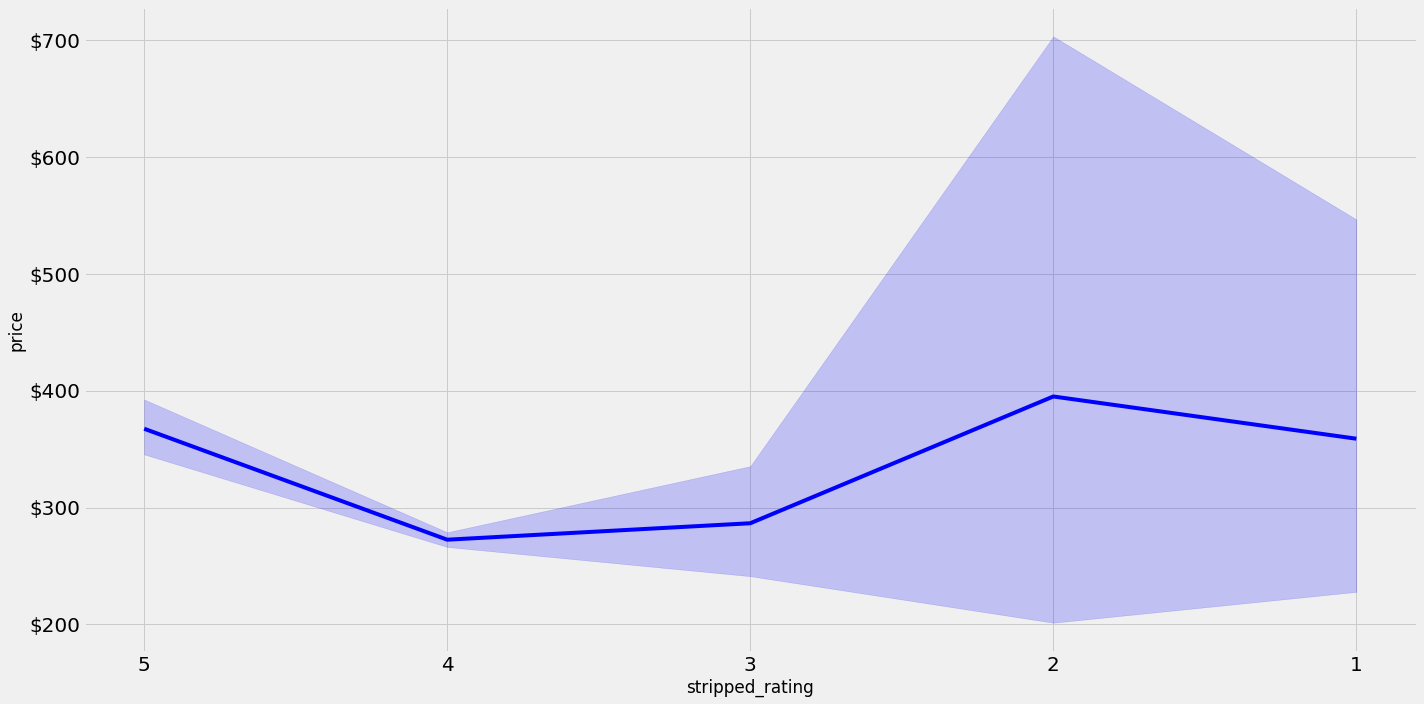

In [40]:
fig, ax = plt.subplots(figsize=(20, 10))

p = sns.lineplot(data=df, x='stripped_rating', y='price', color='blue');


#p.set_xlabel("Date", fontsize = 30)
#p.set_ylabel("Average Home Prices (Median)", fontsize = 30)

#y1 = p.axvline('2008-01', color='red') #housing market crash begins
#y2 = p.axvline('2012-01', color='red') #housing market crash ends

plt.xticks(fontsize=20)
plt.yticks(fontsize=20)

fmt = '${x:,.0f}'
tick = mtick.StrMethodFormatter(fmt)
ax.yaxis.set_major_formatter(tick) 

#p.set_title("US Median Home Prices", fontsize = 55)
plt.figsize=(50,25)
#plt.savefig('images/us_median_plot_1')

plt.tight_layout()

plt.show();

### Analysis: 
This is a very basic plot, but seems to show that there is a "sweet spot" for pricing that is around $300.

In [41]:
#new_df = df[df['5+_reviews'] == True]

KeyError: '5+_reviews'

In [ ]:
#new_df['5+_reviews'].value_counts()

In [ ]:
fig, ax = plt.subplots(figsize=(20, 10))

p = sns.lineplot(data=new_df, x='stripped_rating', y='price', color='blue');


#p.set_xlabel("Date", fontsize = 30)
#p.set_ylabel("Average Home Prices (Median)", fontsize = 30)

#y1 = p.axvline('2008-01', color='red') #housing market crash begins
#y2 = p.axvline('2012-01', color='red') #housing market crash ends

plt.xticks(fontsize=20)
plt.yticks(fontsize=20)

fmt = '${x:,.0f}'
tick = mtick.StrMethodFormatter(fmt)
ax.yaxis.set_major_formatter(tick) 

#p.set_title("US Median Home Prices", fontsize = 55)
plt.figsize=(50,25)
#plt.savefig('images/us_median_plot_1')

plt.tight_layout()

plt.show();

In [42]:
scatter_df = df[df['review_scores_rating'] >= 4.0]

In [43]:
scatter_mean = scatter_df['price'].mean()
scatter_mean

294.45981924767955

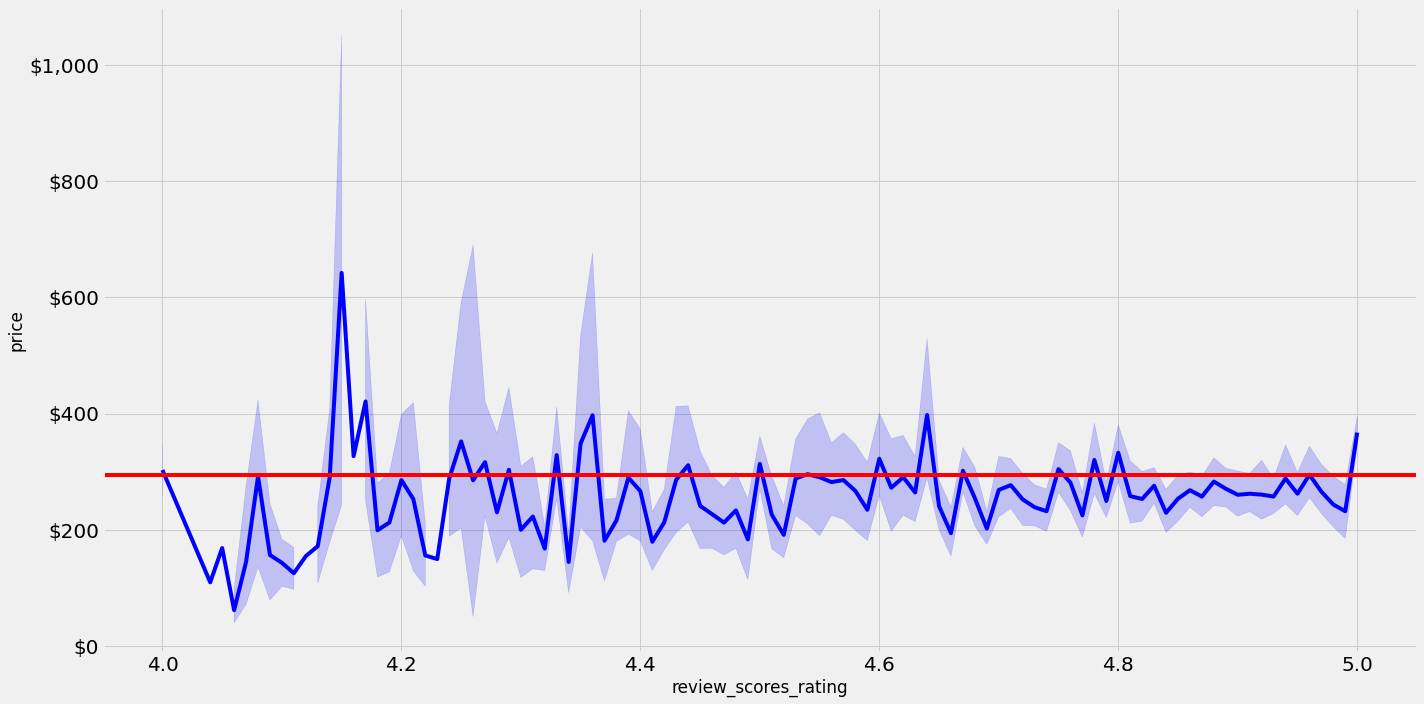

In [44]:
fig, ax = plt.subplots(figsize=(20, 10))

p = sns.lineplot(data=scatter_df, x='review_scores_rating', y='price', color='blue');


#p.set_xlabel("Date", fontsize = 30)
#p.set_ylabel("Average Home Prices (Median)", fontsize = 30)

y1 = p.axhline(scatter_mean, color='red') 
#y2 = p.axvline('2012-01', color='red') #housing market crash ends

plt.xticks(fontsize=20)
plt.yticks(fontsize=20)

fmt = '${x:,.0f}'
tick = mtick.StrMethodFormatter(fmt)
ax.yaxis.set_major_formatter(tick) 

#p.set_title("US Median Home Prices", fontsize = 55)
plt.figsize=(50,25)
#plt.savefig('images/us_median_plot_1')

plt.tight_layout()

plt.show();

In [45]:
df.head(1)

,price,review_scores_rating,review_scores_accuracy,review_scores_cleanliness,review_scores_checkin,review_scores_communication,review_scores_location,review_scores_value,accommodates,bedrooms,...,bedrooms_4+,rating_5,accuracy_5,cleanliness_5,checkin_5,location_5,value_5,price_high,price_low,stripped_rating
0,60.0,5.0,5.0,5.0,5.0,5.0,4.0,5.0,2,1.0,...,False,True,True,True,True,False,True,False,True,5


In [46]:
df.sort_values('rating_5', ascending=False).head()

,price,review_scores_rating,review_scores_accuracy,review_scores_cleanliness,review_scores_checkin,review_scores_communication,review_scores_location,review_scores_value,accommodates,bedrooms,...,bedrooms_4+,rating_5,accuracy_5,cleanliness_5,checkin_5,location_5,value_5,price_high,price_low,stripped_rating
0,60.0,5.0,5.0,5.0,5.00,5.00,4.0,5.00,2,1.0,...,False,True,True,True,True,False,True,False,True,5
740,1185.0,5.0,5.0,5.0,4.40,3.80,5.0,5.00,12,3.0,...,False,True,True,True,False,True,True,True,False,5
9722,379.0,5.0,5.0,5.0,5.00,5.00,5.0,5.00,8,3.0,...,False,True,True,True,True,True,True,True,False,5
9718,55.0,5.0,5.0,4.0,5.00,5.00,4.0,4.00,1,1.0,...,False,True,True,False,True,False,False,False,True,5
4819,519.0,5.0,5.0,5.0,4.93,4.93,4.6,4.97,7,4.0,...,True,True,True,True,False,False,False,True,False,5


In [ ]:
df.info()

## Getting Data Ready for Modelling

In [47]:
cont_features = [col for col in df.columns if df[col].dtype in [np.float64, np.int64]]
feature_df = df.loc[:, cont_features]
feature_df.head()

,price,review_scores_rating,review_scores_accuracy,review_scores_cleanliness,review_scores_checkin,review_scores_communication,review_scores_location,review_scores_value,accommodates,bedrooms,beds
0,60.0,5.0,5.0,5.00,5.0,5.0,4.00,5.00,2,1.0,1.0
1900,500.0,5.0,5.0,4.91,5.0,5.0,5.00,4.73,6,3.0,3.0
1886,386.0,5.0,5.0,5.00,5.0,5.0,5.00,5.00,5,2.0,3.0
8315,152.0,5.0,5.0,5.00,5.0,5.0,5.00,5.00,2,1.0,2.0
8311,552.0,5.0,5.0,5.00,5.0,5.0,4.83,4.83,6,3.0,3.0


In [48]:
feature_df

,price,review_scores_rating,review_scores_accuracy,review_scores_cleanliness,review_scores_checkin,review_scores_communication,review_scores_location,review_scores_value,accommodates,bedrooms,beds
0,60.0,5.0,5.0,5.00,5.0,5.0,4.00,5.00,2,1.0,1.0
1900,500.0,5.0,5.0,4.91,5.0,5.0,5.00,4.73,6,3.0,3.0
1886,386.0,5.0,5.0,5.00,5.0,5.0,5.00,5.00,5,2.0,3.0
8315,152.0,5.0,5.0,5.00,5.0,5.0,5.00,5.00,2,1.0,2.0
8311,552.0,5.0,5.0,5.00,5.0,5.0,4.83,4.83,6,3.0,3.0
...,...,...,...,...,...,...,...,...,...,...,...
5239,61.0,1.0,1.0,1.00,3.0,3.0,5.00,3.00,1,1.0,1.0
4942,299.0,1.0,1.0,3.00,1.0,1.0,1.00,1.00,4,1.0,1.0
6244,380.0,1.0,1.0,1.00,1.0,1.0,1.00,1.00,6,2.0,3.0
1725,250.0,1.0,1.0,1.00,1.0,1.0,1.00,1.00,1,1.0,1.0


In [49]:
feature_df.drop([ 'review_scores_rating', 'review_scores_accuracy','review_scores_cleanliness',
                 'review_scores_checkin', 'review_scores_communication','review_scores_value',
                 'review_scores_location', 'accommodates', 'bedrooms',
                 'beds'], axis=1, inplace=True)

In [ ]:
#feature_df.drop(['review_scores_location'], axis=1, inplace=True)

In [50]:
feature_df.head()

,price
0,60.0
1900,500.0
1886,386.0
8315,152.0
8311,552.0


In [52]:
df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 8385 entries, 0 to 9846
Data columns (total 32 columns):
 #   Column                       Non-Null Count  Dtype  
---  ------                       --------------  -----  
 0   price                        8385 non-null   float64
 1   review_scores_rating         8385 non-null   float64
 2   review_scores_accuracy       8385 non-null   float64
 3   review_scores_cleanliness    8385 non-null   float64
 4   review_scores_checkin        8385 non-null   float64
 5   review_scores_communication  8385 non-null   float64
 6   review_scores_location       8385 non-null   float64
 7   review_scores_value          8385 non-null   float64
 8   accommodates                 8385 non-null   int64  
 9   bedrooms                     8385 non-null   float64
 10  beds                         8385 non-null   float64
 11  instant_bookable             8385 non-null   object 
 12  property_type                8385 non-null   object 
 13  room_type         

### One Hot Encoding

In [53]:
need_to_encode = df[['rating_5', 'accuracy_5', 'cleanliness_5', 'checkin_5', 
                    'location_5', 'value_5', 'price_high', 'price_low',
                    'capacity_0-2', 'capacity_3-4', 'capacity_5-9', 'capacity_10+',
                    'bedrooms_1', 'bedrooms_2', 'bedrooms_3', 'bedrooms_4+', 'instant_bookable']]
ohe = OneHotEncoder()
ohe.fit(need_to_encode)

ohe_1 = ohe.transform(need_to_encode).toarray()

ohe_df = pd.DataFrame(ohe_1, columns=ohe.get_feature_names(need_to_encode.columns))
ohe_df.head(2)

,rating_5_False,rating_5_True,accuracy_5_False,accuracy_5_True,cleanliness_5_False,cleanliness_5_True,checkin_5_False,checkin_5_True,location_5_False,location_5_True,...,bedrooms_1_False,bedrooms_1_True,bedrooms_2_False,bedrooms_2_True,bedrooms_3_False,bedrooms_3_True,bedrooms_4+_False,bedrooms_4+_True,instant_bookable_f,instant_bookable_t
0,0.0,1.0,0.0,1.0,0.0,1.0,0.0,1.0,1.0,0.0,...,0.0,1.0,1.0,0.0,1.0,0.0,1.0,0.0,0.0,1.0
1,0.0,1.0,0.0,1.0,1.0,0.0,0.0,1.0,0.0,1.0,...,1.0,0.0,1.0,0.0,0.0,1.0,1.0,0.0,1.0,0.0


In [54]:
# Combining everything together
cleaned_df = pd.concat([pd.DataFrame(feature_df), ohe_df], axis=1)
cleaned_df.head(2)

,price,rating_5_False,rating_5_True,accuracy_5_False,accuracy_5_True,cleanliness_5_False,cleanliness_5_True,checkin_5_False,checkin_5_True,location_5_False,...,bedrooms_1_False,bedrooms_1_True,bedrooms_2_False,bedrooms_2_True,bedrooms_3_False,bedrooms_3_True,bedrooms_4+_False,bedrooms_4+_True,instant_bookable_f,instant_bookable_t
0,60.0,0.0,1.0,0.0,1.0,0.0,1.0,0.0,1.0,1.0,...,0.0,1.0,1.0,0.0,1.0,0.0,1.0,0.0,0.0,1.0
1,282.0,0.0,1.0,0.0,1.0,1.0,0.0,0.0,1.0,0.0,...,1.0,0.0,1.0,0.0,0.0,1.0,1.0,0.0,1.0,0.0


#### Dropping One Value for Categoricals

In [56]:
#Dropping a few of the redundant values.
cleaned_df= cleaned_df.drop(['rating_5_False', 'accuracy_5_False',
                             'cleanliness_5_False', 'checkin_5_False', 'location_5_False',
                             'value_5_False', 'price_high_False', 'price_low_False',
                            'bedrooms_1_False', 'bedrooms_2_False', 'bedrooms_3_False', 'bedrooms_4+_False',
                            'capacity_0-2_False', 'capacity_3-4_False', 'capacity_5-9_False',
                            'capacity_10+_False', 'instant_bookable_f'], axis=1)

In [58]:
#cleaned_df= cleaned_df.drop(['price_low_True', 'price_high_True'], axis=1)
cleaned_df= cleaned_df.drop(['price'], axis=1)

In [59]:
cleaned_df.head(1)

,rating_5_True,accuracy_5_True,cleanliness_5_True,checkin_5_True,location_5_True,value_5_True,price_high_True,price_low_True,capacity_0-2_True,capacity_10+_True,bedrooms_1_True,bedrooms_2_True,bedrooms_3_True,bedrooms_4+_True,instant_bookable_t
0,1.0,1.0,1.0,1.0,0.0,1.0,0.0,1.0,1.0,0.0,1.0,0.0,0.0,0.0,1.0


## Dealing with Class Imbalance
- Always use class weight parameter in Decision Tree Classifier
- Always stratify Train Test Split.
- Add SMOTE to Training Sets.

In [60]:
cleaned_df['rating_5_True'].value_counts()

0.0    6491
1.0    1894
Name: rating_5_True, dtype: int64

In [61]:
cleaned_df.isna().sum()

rating_5_True         1505
accuracy_5_True       1505
cleanliness_5_True    1505
checkin_5_True        1505
location_5_True       1505
value_5_True          1505
price_high_True       1505
price_low_True        1505
capacity_0-2_True     1505
capacity_10+_True     1505
bedrooms_1_True       1505
bedrooms_2_True       1505
bedrooms_3_True       1505
bedrooms_4+_True      1505
instant_bookable_t    1505
dtype: int64

In [62]:
cleaned_df = cleaned_df.dropna()

In [63]:
cleaned_df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 8385 entries, 0 to 8384
Data columns (total 15 columns):
 #   Column              Non-Null Count  Dtype  
---  ------              --------------  -----  
 0   rating_5_True       8385 non-null   float64
 1   accuracy_5_True     8385 non-null   float64
 2   cleanliness_5_True  8385 non-null   float64
 3   checkin_5_True      8385 non-null   float64
 4   location_5_True     8385 non-null   float64
 5   value_5_True        8385 non-null   float64
 6   price_high_True     8385 non-null   float64
 7   price_low_True      8385 non-null   float64
 8   capacity_0-2_True   8385 non-null   float64
 9   capacity_10+_True   8385 non-null   float64
 10  bedrooms_1_True     8385 non-null   float64
 11  bedrooms_2_True     8385 non-null   float64
 12  bedrooms_3_True     8385 non-null   float64
 13  bedrooms_4+_True    8385 non-null   float64
 14  instant_bookable_t  8385 non-null   float64
dtypes: float64(15)
memory usage: 1.0 MB


In [64]:
cleaned_df.isna().sum()

rating_5_True         0
accuracy_5_True       0
cleanliness_5_True    0
checkin_5_True        0
location_5_True       0
value_5_True          0
price_high_True       0
price_low_True        0
capacity_0-2_True     0
capacity_10+_True     0
bedrooms_1_True       0
bedrooms_2_True       0
bedrooms_3_True       0
bedrooms_4+_True      0
instant_bookable_t    0
dtype: int64

In [ ]:
#cleaned_df.drop(['number_of_reviews', 'number_of_reviews_ltm', 'number_of_reviews_l30d', 'price'], axis=1, inplace=True)

In [65]:
balanced_df = cleaned_df.copy()

X = balanced_df.drop(['rating_5_True'], axis=1)
y = balanced_df['rating_5_True']

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=.25, stratify=y, random_state=23)

smote = SMOTE(random_state=23)
X_train_resampled, y_train_resampled = smote.fit_sample(X_train, y_train) 

### Metrics Function

In [66]:
def get_metrics(clf, y_pred):
    
    
    #clf_acc = accuracy_score(y_test, y_pred) * 100
    #print('Accuracy is :{0}'.format(clf_acc))
    #clf_prec = precision_score(y_test, y_pred) * 100
    #print('Precision is :{0}'.format(clf_prec))
    clf_rcl = recall_score(y_test, y_pred) * 100
    print('Recall is :{0}'.format(clf_rcl))
    clf_f1 = f1_score(y_test, y_pred) * 100
    print('F1 Score is :{0}'.format(clf_f1))
    false_positive_rate, true_positive_rate, thresholds = roc_curve(y_test, y_pred)
    clf_roc_auc = auc(false_positive_rate, true_positive_rate)
    print('ROC AUC is :{0}'.format(round(clf_roc_auc, 2)))

## Baseline Decision Tree

In [ ]:
dt1 = DecisionTreeClassifier(random_state=23, class_weight="balanced")
dt1.fit(X_train_resampled, y_train_resampled)
dt1_y_pred = dt1.predict(X_test)

In [ ]:
get_metrics(dt1, dt1_y_pred)

In [ ]:
dt1_cv_score = np.mean(cross_val_score(dt1, X_train_resampled, y_train_resampled, cv=3))
dt1_cv_score

In [ ]:
dt1_matrix = confusion_matrix(y_test, dt1_y_pred)

fig, ax = plt.subplots(figsize=(5,5))

ax = sns.heatmap(dt1_matrix, annot=True, cmap='Blues', fmt='d')

ax.set_title('Baseline Decision Tree Confusion Matrix', fontsize = 30);
ax.set_xlabel('\nPredicted Values',fontsize = 20)
ax.set_ylabel('Actual Values ', fontsize=20);

## Ticket labels - List must be in alphabetical order
ax.xaxis.set_ticklabels(['Bad Score','5.0 Score'])
ax.yaxis.set_ticklabels(['Bad Score','5.0 Score'])

## Display the visualization of the Confusion Matrix.
plt.show()

### Refining Decision Tree through GridSearchCV

In [ ]:
dt_param_grid = {
    'criterion': ['gini', 'entropy'],
    'max_depth': [None, 2, 3, 4, 5, 6],
    'min_samples_split': [2, 5, 10],
    'min_samples_leaf': [1, 2, 3, 4, 5, 6]
}

In [ ]:
# Instantiate GridSearchCV
dt2 = DecisionTreeClassifier(random_state=23)

dt_grid_search = GridSearchCV(dt2, dt_param_grid, cv=3, scoring = 'recall')

# Fit to the data
dt_grid_search.fit(X_train_resampled, y_train_resampled)

In [ ]:
dt_grid_search.best_params_

## Decision Tree 2

In [ ]:
dt2 = DecisionTreeClassifier(criterion='entropy', max_depth=4, min_samples_split=2,
                             min_samples_leaf=1, class_weight='balanced', random_state=23)
dt2.fit(X_train_resampled, y_train_resampled)
dt2_y_pred = dt2.predict(X_test)

In [ ]:
get_metrics(dt2, dt2_y_pred)

In [ ]:
dt2_cv_score = np.mean(cross_val_score(dt2, X_train_resampled, y_train_resampled, cv=3))
dt2_cv_score

In [ ]:
dt2_matrix = confusion_matrix(y_test, dt2_y_pred)

fig, ax = plt.subplots(figsize=(5,5))

ax = sns.heatmap(dt2_matrix, annot=True, cmap='Blues', fmt='d')

ax.set_title('Decision Tree 2 Confusion Matrix', fontsize = 30);
ax.set_xlabel('\nPredicted Values',fontsize = 20)
ax.set_ylabel('Actual Values ', fontsize=20);

## Ticket labels - List must be in alphabetical order
ax.xaxis.set_ticklabels(['Bad Score','5.0 Score'])
ax.yaxis.set_ticklabels(['Bad Score','5.0 Score'])

## Display the visualization of the Confusion Matrix.
plt.show()

## Random Forests

In [ ]:
rf1_clf = RandomForestClassifier(random_state=23, class_weight="balanced")
rf1_clf.fit(X_train_resampled, y_train_resampled)
rf1_y_pred = rf1_clf.predict(X_test)

In [ ]:
get_metrics(rf1_clf, rf1_y_pred)

In [ ]:
rf1_cv_score = np.mean(cross_val_score(rf1_clf, X_train_resampled, y_train_resampled, cv=3))
rf1_cv_score

### GridSearch CV

In [ ]:
rf_param_grid = {
    'n_estimators': [10, 30, 100],
    'criterion': ['gini', 'entropy'],
    'max_depth': [None, 2, 6, 10],
    'min_samples_split': [5, 10],
    'min_samples_leaf': [3, 6]
}

In [ ]:
rf2_clf = RandomForestClassifier(random_state=23)


rf1_grid_search= GridSearchCV(rf2_clf, rf_param_grid, scoring = 'recall', cv=3)
rf1_grid_search.fit(X_train_resampled, y_train_resampled)

print("")
print(f"Random Forest  Optimal Parameters: {rf1_grid_search.best_params_}")

## Random Forests 2

In [ ]:
rf2_clf = RandomForestClassifier(criterion= 'entropy', max_depth= 2, min_samples_leaf= 3,
                                min_samples_split= 5, n_estimators= 30, random_state=23,
                                class_weight='balanced')
rf2_clf.fit(X_train_resampled, y_train_resampled)
rf2_y_pred = rf2_clf.predict(X_test)

In [ ]:
get_metrics(rf2_clf, rf2_y_pred)

In [ ]:
rf2_cv_score = np.mean(cross_val_score(rf2_clf, X_train_resampled, y_train_resampled, cv=3))
rf2_cv_score

## XGBoost Model

In [ ]:
# Instantiate XGBClassifier
clf = XGBClassifier(random_state=23)

# Fit XGBClassifier
xg1 = clf.fit(X_train_resampled, y_train_resampled)

# Predict on training and test sets
training_preds = clf.predict(X_train_resampled)
xg1_y_pred = clf.predict(X_test)

In [ ]:
get_metrics(xg1, xg1_y_pred)

In [ ]:
xg1_cv_score = np.mean(cross_val_score(xg1, X_train_resampled, y_train_resampled, cv=3))
xg1_cv_score

### GridSearch

In [ ]:
boost_param_grid = {
    'learning_rate': [0.1, 0.2],
    'max_depth': [6],
    'min_child_weight': [1, 2],
    'subsample': [0.5, 0.7],
    'n_estimators': [100],
}

## XGBoost 2

In [ ]:
xg2 = XGBClassifier(random_state=23)

grid_clf = GridSearchCV(xg2, boost_param_grid, scoring='recall', cv=3, n_jobs=1)
grid_clf.fit(X_train_resampled, y_train_resampled)

best_parameters = grid_clf.best_params_

print('Grid Search found the following optimal parameters: ')
for param_name in sorted(best_parameters.keys()):
    print('%s: %r' % (param_name, best_parameters[param_name]))

In [ ]:
xg2 = XGBClassifier(learning_rate= 0.2, max_depth=6, min_child_weight=2,
                                n_estimators=100, subsample=0.5, random_state=23)
xg2.fit(X_train_resampled, y_train_resampled)
xg2_y_pred = xg2.predict(X_test)

In [ ]:
get_metrics(xg2, xg2_y_pred)

In [ ]:
xg2_cv_score = np.mean(cross_val_score(xg2, X_train_resampled, y_train_resampled, cv=3))
xg2_cv_score

In [ ]:
xg2_matrix = confusion_matrix(y_test, xg2_y_pred)

fig, ax = plt.subplots(figsize=(5,5))

ax = sns.heatmap(xg2_matrix, annot=True, cmap='Blues', fmt='d')

ax.set_title('XG Boost 2 Confusion Matrix', fontsize = 30);
ax.set_xlabel('\nPredicted Values',fontsize = 20)
ax.set_ylabel('Actual Values ', fontsize=20);

## Ticket labels - List must be in alphabetical order
ax.xaxis.set_ticklabels(['Bad Score','5.0 Score'])
ax.yaxis.set_ticklabels(['Bad Score','5.0 Score'])

## Display the visualization of the Confusion Matrix.
plt.show()

## FINAL MODEL = Decision Tree 2

## Feature Importance

In [ ]:
feature_names = list(X)
feature_names

In [ ]:
dt2_importance = dt2.feature_importances_
dt2_importance

In [ ]:
feature_importance_df = pd.DataFrame(dt2_importance, feature_names)
#feature_importance_df = pd.DataFrame(rf2_importance, feature_names)
#feature_importance_df = pd.DataFrame(xg2_importance, feature_names)
feature_importance_df= feature_importance_df.reset_index()
feature_importance_df.rename(columns={'index': 'Feature', 0: 'Importance'}, inplace=True)
feature_importance_df = feature_importance_df.sort_values('Importance', ascending=False)
feature_importance_df

In [ ]:
# plot feature importance
fig, ax = plt.subplots(figsize=(50,20))
p = sns.barplot(data=feature_importance_df, x='Importance', y='Feature', color ='mediumpurple' );
p.set_xlabel("Importance", fontsize = 50)

p.set_ylabel("Feature", fontsize = 50)
plt.xticks(fontsize=40)
plt.yticks(fontsize=40)

p.set_title("Features by Importance", fontsize = 100)
plt.figsize=(30,20) 

plt.show();